Introduccion Ragas

En este ejemplo utilizamos Ragas, un framework diseñado para evaluar pipelines de Retrieval-Augmented Generation (RAG), de manera offline sin depender de modelos de lenguaje externos.

Ragas permite medir qué tan efectivas son las respuestas generadas por un sistema RAG en función de los contextos recuperados y las respuestas esperadas. En particular, en este demo evaluamos dos métricas principales:
	1.	Context Precision (NonLLMContextPrecisionWithReference):
Mide qué proporción de los contextos recuperados son realmente relevantes para responder la pregunta. Una precisión alta indica que la mayoría de los fragmentos de contexto contienen información útil.
	2.	Context Recall (NonLLMContextRecall):
Mide si al menos un contexto relevante fue recuperado para cada pregunta. Un recall alto indica que la información clave necesaria para responder está presente en los fragmentos recuperados.

Este enfoque nos permite:
	•	Evaluar pipelines RAG sin necesidad de conexión a APIs de OpenAI ni otros LLMs, usando únicamente los textos de contexto.
	•	Obtener métricas por pregunta y un promedio general del desempeño del sistema.
	•	Visualizar de manera rápida qué preguntas tienen contextos más completos y relevantes, ayudando a identificar oportunidades de mejora en la recuperación de información.

En resumen, Ragas nos permite medir la calidad de la recuperación de información y la relevancia de los contextos de forma estructurada y reproducible, lo que es clave para optimizar cualquier sistema RAG.

In [22]:
# Instalar dependencias
!pip install ragas datasets evaluate rapidfuzz --quiet

from ragas import evaluate
from ragas.metrics import NonLLMContextRecall, NonLLMContextPrecisionWithReference
from datasets import Dataset
import pandas as pd


In [23]:
# Dataset de ejemplo
data = {
    "question": [
        "¿Cuál es la capital de Francia?",
        "¿Quién escribió La República?",
    ],
    "contexts": [
        ["París es la capital de Francia.", "Ciudad francesa."],
        ["Platón fue un filósofo griego.", "La República fue escrita por Platón."],
    ],
    "reference_contexts": [
        ["París es la capital de Francia."],
        ["La República es un diálogo de Platón."],
    ],
    "answer": ["París.", "Platón."],
    "ground_truth": ["París", "Platón"],
}

dataset = Dataset.from_dict(data)


In [24]:
# Inicializamos métricas sin LLM
metrics = [
    NonLLMContextPrecisionWithReference(),
    NonLLMContextRecall(),
]

In [25]:
# Evaluamos (100% offline)
result = evaluate(dataset, metrics=metrics, llm=None, embeddings=None, raise_exceptions=False)
df = result.to_pandas()


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

In [26]:
# Mostrar columnas disponibles
print("Columnas en el DataFrame:\n", df.columns)

# Resultados por pregunta
print("\nResultados por muestra:")
print(df[['non_llm_context_precision_with_reference', 'non_llm_context_recall']])

# Promedio general
print("\nPromedios:")
print(df[['non_llm_context_precision_with_reference', 'non_llm_context_recall']].mean())

Columnas en el DataFrame:
 Index(['user_input', 'retrieved_contexts', 'reference_contexts', 'response',
       'reference', 'non_llm_context_precision_with_reference',
       'non_llm_context_recall'],
      dtype='object')

Resultados por muestra:
   non_llm_context_precision_with_reference  non_llm_context_recall
0                                       1.0                     1.0
1                                       0.5                     1.0

Promedios:
non_llm_context_precision_with_reference    0.75
non_llm_context_recall                      1.00
dtype: float64


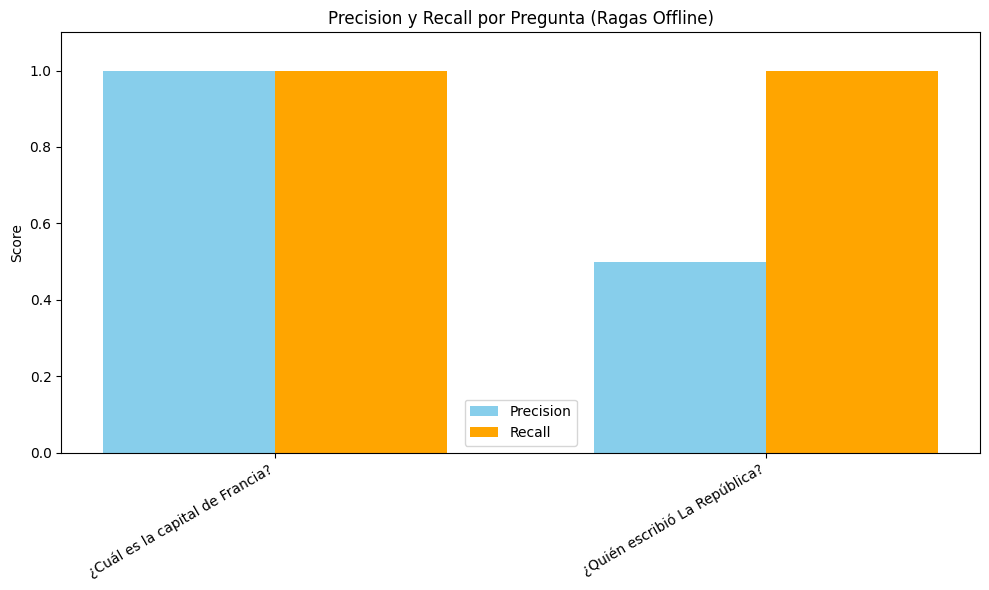

In [30]:
import matplotlib.pyplot as plt

# Preguntas como etiquetas
questions = df['user_input'] if 'user_input' in df.columns else df['question']

# Valores de precision y recall
precision = df['non_llm_context_precision_with_reference']
recall = df['non_llm_context_recall']

# Configuración del gráfico
x = range(len(questions))
width = 0.35  # ancho de las barras

fig, ax = plt.subplots(figsize=(10,6))
ax.bar([i - width/2 for i in x], precision, width, label='Precision', color='skyblue')
ax.bar([i + width/2 for i in x], recall, width, label='Recall', color='orange')

# Etiquetas y títulos
ax.set_xticks(x)
ax.set_xticklabels(questions, rotation=30, ha='right')
ax.set_ylim(0, 1.1)
ax.set_ylabel('Score')
ax.set_title('Precision y Recall por Pregunta (Ragas Offline)')
ax.legend()

plt.tight_layout()
plt.show()